In [1]:
%load_ext autoreload
%autoreload
from tune_and_draw import TuneAndDraw
from fedhybrid_innerloops import FedHybrid
from parameter import TuneParam,TrainParam
from costFunc import LogisticCostFunc
import numpy as np
import random
from sklearn.datasets import load_boston
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
from datetime import datetime
import json
import pandas as pd
import numpy as np
import random
from scipy.optimize import minimize

In [2]:
def saved_data(nclient):
    with open('setup_3_result/train_data0'+str(nclient)+'.json', 'r') as fp: # data from xiaochun code
        train_data = json.load(fp)

        
    df_train = pd.DataFrame.from_dict(train_data['user_data'])
    df_train = df_train.T

    A_train = df_train['x'].to_numpy()
    y_train = df_train['y'].to_numpy()

    for i in range(nclient):
        A_train[i]= np.array(A_train[i])
        y_train[i] = np.array(y_train[i])

    return A_train, y_train

In [3]:
'''
for each device k, we generate samples (Xk, Yk) according to the model y = argmax(softmax(W x + b)), 
x ∈R60, W ∈ R10×60, b ∈ R10. We model Wk ∼ N (uk, 1),
bk ∼ N (uk, 1), uk ∼ N (0, α); xk ∼ N (vk, Σ), where the
covariance matrix Σ is diagonal with Σj,j = j^−1.2.
Each element in the mean vector vk is drawn from N (Bk, 1), Bk ∼N(0, β).
Therefore, α controls how much local models differ from each other and β controls how much the local data
at each device differs from that of other devices. 
We vary α, β to generate three heterogeneous distributed datasets,
denoted Synthetic (α, β), as shown in Figure 2. We also
generate one IID dataset by setting the same W, b on all
devices and setting Xk to follow the same distribution. Our
goal is to learn a global W and b.
'''
class SampleParam: 
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma


def softmax(z):
    ex = np.exp(z)
    sum_ex = np.sum(np.exp(z))
    return ex/sum_ex       

def dataset(nclient,n):    
    nsample_param=SampleParam(4,2)
    prior_param=SampleParam(0,0.5)
    ndim=12
    nclass=2
    print('local datasizes')
    np.random.seed(2022)
    random.seed(2022)
    
    #ni = np.random.lognormal(nsample_param.mean, nsample_param.sigma, nclient).astype(int) + 50 # number of samples per client
    if nclient == 8 and n == 354:
        ni=[45, 38, 29, 12, 62, 76, 36, 56]
    else:
        p = np.zeros(nclient)
        s = 0
        for i in range(nclient):
            p[i] = random.uniform(0.1, 1)
            s += p[i]
        p = p/s
        print(p)
        ni = p * n
        ni = [int(num) for num in ni]
        ni[-1] = ni[-1] + n - sum(ni)
     
    
    
    A0 = [[] for _ in range(nclient)]
    y0 = [[] for _ in range(nclient)]
        #### define some eprior ####

    mean_W = np.random.normal(prior_param.mean, prior_param.sigma, nclient)
    print(prior_param.sigma)
    mean_b = mean_W
    mean_x = np.random.normal(prior_param.mean, prior_param.sigma, nclient)
    mean_x = np.zeros((nclient, ndim))
    for i in range(nclient):
        mean_x[i] = np.random.normal(mean_x[i], 1, ndim)
    diagonal = np.zeros(ndim)
    for j in range(ndim):
        diagonal[j] = np.power((j+1), -1.2)
    cov_x = np.diag(diagonal)
    for i in range(nclient):
        W = np.random.normal(mean_W[i], 1, (ndim, nclass))
        b = np.random.normal(mean_b[i], 1,  nclass)
        Ai = np.random.multivariate_normal(mean_x[i], cov_x, ni[i])
        yi = np.zeros(ni[i])
        for j in range(ni[i]):
            tmp = np.dot(Ai[j], W) + b
            yi[j] = np.argmax(softmax(tmp))
        A0[i] = Ai.tolist()
        y0[i] = yi.tolist()
#print('dsfadf',y0[5])
    train_data = {'users': [], 'user_data':{}, 'num_samples':[]}

    for i in range(nclient):
        uname = 'f_{0:05d}'.format(i)        
        combined = list(zip(A0[i], y0[i]))
        random.shuffle(combined)
        A0[i][:], y0[i][:] = zip(*combined) # The * operator can be used in conjunction with zip() to unzip the list.
        num_samples = len(A0[i])
        train_data['users'].append(uname) 
        train_data['user_data'][uname] = {'x': A0[i], 'y': y0[i]}
        train_data['num_samples'].append(num_samples)
        with open('setup_3_result/train_data0'+str(nclient)+'_'+str(n)+'.json', 'w') as fp:
            json.dump(train_data, fp)
        print(num_samples)


In [4]:
def prepare(nclient):

    #dataset(nclient,n)
    A, y =saved_data(nclient)
    gamma = 1
    func = LogisticCostFunc(A, y, gamma)
    initial_x =np.array( [[0.99846005],
    [0.14017568],
    [0.43901654],
    [0.71784581],
    [0.83952553],
    [0.00799748],
    [0.7440322 ],
    [0.78949782],
    [0.12399082],
    [0.85932448],
    [0.21513528],
    [0.91062862]])
    fn_min = minimize(func.global_func, initial_x, tol=1e-30) #result object
    fn_star = fn_min.fun
    method = FedHybrid(func, fn_star)
#ns=[0,2,4,6,8]
#innerIterations = 3
    tuneAndDraw = TuneAndDraw(nclient, initial_x,setup=3)
    return method,tuneAndDraw
#tuneAndDraw.draw(method,ns,innerIterations,method.train_innerloop_lambdaBefore)


node 8, n = 354, synchronous synthetic logistic regreesion

data int64
1.928341486490126e-09 231 1
1.6484436038410877e-09 178 1
1.896152124203354e-09 129 1
1.793779791370298e-09 99 1
1.557179718503221e-09 19 1


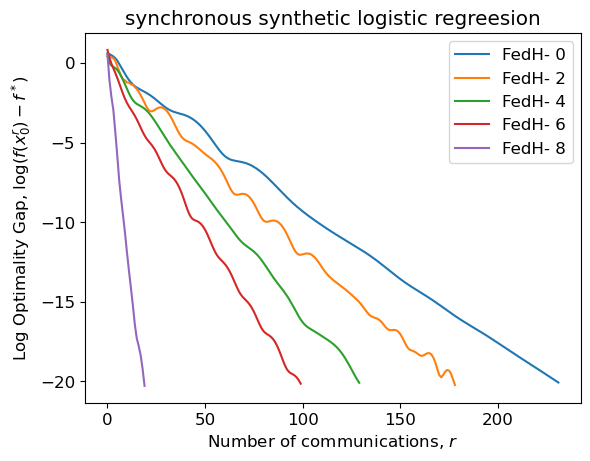

In [22]:
method,tuneAndDraw = prepare(8)
ns=[0,2,4,6,8]
innerIterations = 1
df = tuneAndDraw.readPa(ns,innerIterations)
filename="./analyze data/analyze data/sync_and_async/3 synchronous synthetic logistic regreesion before.pdf"
tuneAndDraw.draw(df,method.train_innerloop_lambdaBefore,"synchronous synthetic logistic regreesion",filename,save = 0,asyn=0,possionBeta=[])

async

data int64
2.023984535526324e-09 19910 1
1.9917019145054837e-09 19634 1
2.04487760058214e-09 3388 1
2.0508146292286256e-09 9284 1
1.6451235929082486e-09 2356 1


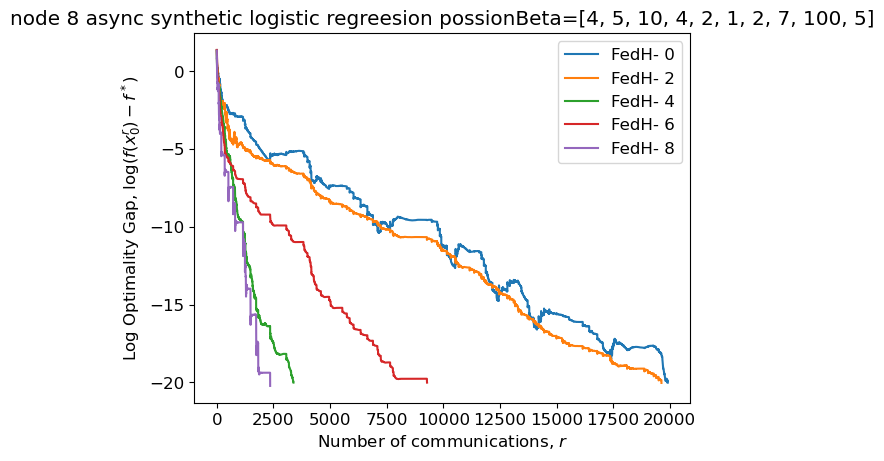

In [26]:
method,tuneAndDraw = prepare(8)
ns=[0,2,4,6,8]
innerIterations = 0
df = tuneAndDraw.readPa(ns,innerIterations)
filename="./analyze data/analyze data/sync_and_async/3 asynchronous synthetic logistic regreesion.pdf"
tuneAndDraw.draw(df,method.asynchronousTrain2,"node 8 async synthetic logistic regreesion possionBeta=[4, 5, 10, 4, 2, 1, 2, 7, 100, 5]",filename,save=1,asyn=1,possionBeta = [4, 5, 10, 1, 2, 7,100,5])

data int64
1.7120127537850749e-09 93 1
1.7173502619982628e-09 80 1
2.0506250031360196e-09 57 1
1.5371126593777262e-09 51 1
1.557179718503221e-09 19 1


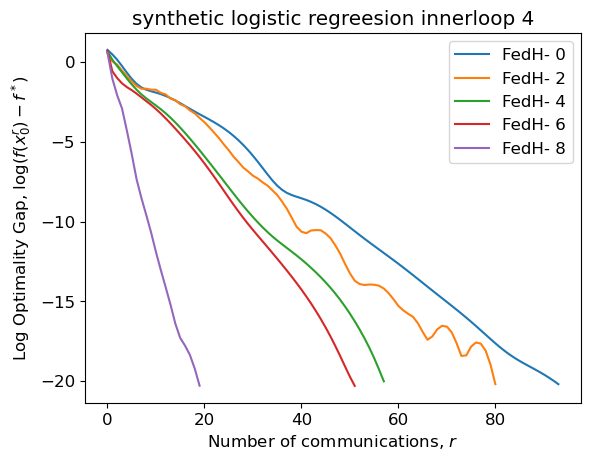

In [7]:
method,tuneAndDraw = prepare(8)
ns=[0,2,4,6,8]
innerIterations = 4
df = tuneAndDraw.readPa(ns,innerIterations)
filename="./analyze data/analyze data/sync_and_async/3 innerloop 4 synthetic logistic regreesion before2.pdf"
tuneAndDraw.draw(df,method.train_innerloop_lambdaBefore,"synthetic logistic regreesion innerloop 4",filename,save =1,asyn=0,possionBeta=[])

In [17]:
nodes = [20,15,10,5]
for nclient in nodes:
    datapoints =5000
    method,tuneAndDraw = prepare(nclient,datapoints)
    if nclient ==15:
        ns=[0,3,6,9,12,15]
    elif nclient == 20:
        ns =[0,3,6,9,12,16,18,20]
    elif nclient ==5:
        ns =[0,1,2,3,4,5]
    elif nclient ==10:
        ns =[0,2,4,6,8,10]
    inner=[1,3,5,7]
    setup=3 
    now = datetime.now() # current date and time
    date_time = now.strftime("%m_%d_%Y, %H_%M")# month date year
    '''
    Best_pa_after_new = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaAfter,'afterNew')
    Best_pa_after_new.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_afterNew'+'.csv',index=False)
    Best_pa_inner = tuneAndDraw.tune(method,ns,inner,method.train_innerloop,'inner')
    Best_pa_inner.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_inner'+'.csv',index=False)
    Best_pa_gra = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_gradient_only,'gradient')
    Best_pa_gra.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_gradient'+'.csv',index=False)
    '''
    #Best_pa_bef = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaBefore,'before')
    
    Best_pa_gra = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_gradient_only,'gradient')
    now = datetime.now() # current date and time
    date_time = now.strftime("%m_%d_%Y, %H_%M")# month date year
    #Best_pa_after_new.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_afterNew'+'.csv',index=False)
    #Best_pa_inner.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_inner'+'.csv',index=False)
    Best_pa_gra.to_csv('./setup_'+str(setup)+'_result/largeScale/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_datapoints_'+str(datapoints)+'_gradient'+'.csv',index=False)
    #Best_pa_bef.to_csv('./setup_'+str(setup)+'_result/nodes/'+'tune_result'+'_'+date_time+'_'+'node_'+str(nclient)+'_before'+'.csv',index=False)


local datasizes
[0.04710516 0.04058104 0.03086649 0.01259835 0.06557381 0.08011441
 0.03836493 0.0546112  0.06757121 0.07125052 0.06391568 0.03075995
 0.05396567 0.04842594 0.04621952 0.0109279  0.06274491 0.02756111
 0.07451685 0.07232535]
0.5
235
202
154
62
327
400
191
273
337
356
319
153
269
242
231
54
313
137
372
373
20
20   0 :  [4, 3, 2, 1, 0, -1, -2, -3] [0, -1, -2, -3, -4, -5, -6, -7, -8, -9] [0] [0] [-8, -7, -6, -5, -4, -3, -2, -1] 600 []
client_gradient [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
client_newton []
<bound method FedHybrid.train_innerloop_gradient_only of <fedhybrid_innerloops.FedHybrid object at 0x7f6f270f1be0>> nclient 20
a_range [4, 3, 2, 1, 0, -1, -2, -3] b_range [0, -1, -2, -3, -4, -5, -6, -7, -8, -9] a2_range [0] b2_range [0] mu_range [-8, -7, -6, -5, -4, -3, -2, -1] newton_client []


In [6]:
inner=[1,2,3,4,5,6,7,8]
tuneAndDraw,method = prepare(8)
ns=[0,2,4,6,8]
#tuneAndDraw.draw(ns,3,method.train_innerloop_lambdaAfter)
#tuneAndDraw.tune(method,ns,inner,method.train_innerloop,'innerloop_odd')
#tuneAndDraw.tune(method,ns,inner,method.train_innerloop_gradient_only,'gradient')
#tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaBefore,'before')
BestPa_after_new = tuneAndDraw.tune(method,ns,inner,method.train_innerloop_lambdaAfter)
#BestPa_after_new.to_csv('./setup_'+str(3)+'_result/largeScale/'+'tune_result'+'_'+date_time+'_'+name+'.csv',index=False)

local datasizes
0.5
45
38
29
12
62
76
36
56


AttributeError: 'FedHybrid' object has no attribute 'tune'

In [ ]:
setup = 3
now = datetime.now() # current date and time
date_time = now.strftime("%m_%d_%Y, %H_%M")# month date year
BestPa_after_new.to_csv('./setup_'+str(setup)+'_result/train/'+'tune_result'+'_'+date_time+'_'+'node_'+str(8)+'_afterNew'+'.csv',index=False)
    

In [ ]:
print(date_time)

07_27_2022, 10_34
